# Universal Pertubations - Playground

## Imports

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
from tensorflow.python.platform import gfile
import os.path
from python.prepare_imagenet_data import preprocess_image_batch, create_imagenet_npy, undo_image_avg
import matplotlib.pyplot as plt
import sys, getopt
import zipfile
from timeit import time
from urllib.request import urlretrieve


from python.universal_pert import universal_perturbation
device = '/gpu:0'
num_classes = 10

2022-03-24 11:40:21.814148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 11:40:21.814173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def jacobian(y_flat, x, inds):
    n = num_classes # Not really necessary, just a quick fix.
    loop_vars = [
         tf.constant(0, tf.int32),
         tf.TensorArray(tf.float32, size=n),
    ]
    _, jacobian = tf.while_loop(
        lambda j,_: j < n,
        lambda j,result: (j+1, result.write(j, tf.gradients(y_flat[inds[j]], x))),
        loop_vars)
    return jacobian.stack()

## Main programm

In [3]:
path_train_imagenet = '/datasets2/ILSVRC2012/train'
path_test_image = 'python/data/test_img.png'

tf_device = tf.device(device)
tf_device.__enter__()
persisted_sess = tf.Session()

2022-03-24 11:40:23.827437: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 11:40:23.827484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archusb): /proc/driver/nvidia/version does not exist
2022-03-24 11:40:23.828470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download inception model

In [4]:
inception_model_path = os.path.join('python', 'data', 'tensorflow_inception_graph.pb')

if os.path.isfile(inception_model_path) == 0:
    print('Downloading Inception model...')
    urlretrieve ("https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip", os.path.join('python', 'data','inception5h.zip'))
    # Unzipping the file
    zip_ref = zipfile.ZipFile(os.path.join('python','data', 'inception5h.zip'), 'r')
    zip_ref.extract('tensorflow_inception_graph.pb', 'python/data')
    zip_ref.close()

### Load inception model

In [5]:
model = os.path.join(inception_model_path)

# Load the Inception model
with gfile.FastGFile(model, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    persisted_sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

Instructions for updating:
Use tf.gfile.GFile.


### Prepare the network & get the universal perturbations vector

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>> Computing feedforward function...
>> Found a pre-computed universal perturbation! Retrieving it from ", file_perturbation


Text(0.5, 1.0, 'Perturbation vector')

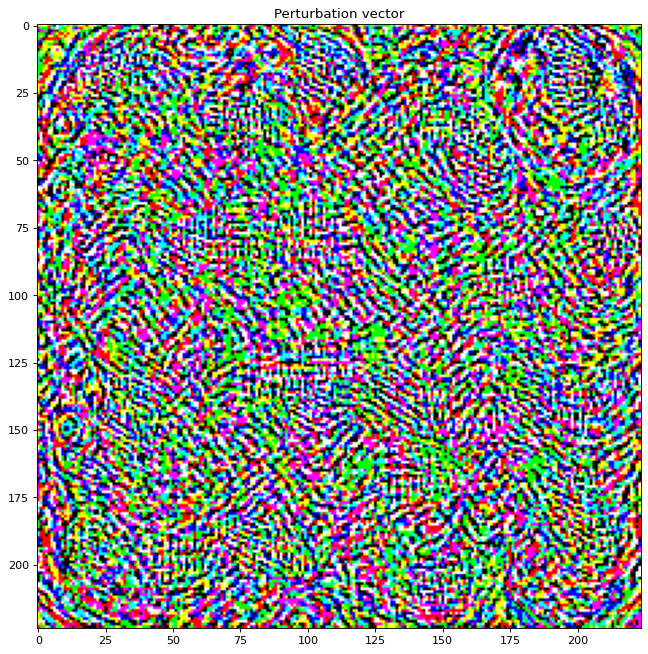

In [6]:
persisted_sess.graph.get_operations()

persisted_input = persisted_sess.graph.get_tensor_by_name("input:0")
persisted_output = persisted_sess.graph.get_tensor_by_name("softmax2_pre_activation:0")


print('>> Computing feedforward function...')
def f(image_inp):
    return persisted_sess.run(persisted_output, feed_dict={persisted_input: np.reshape(image_inp, (-1, 224, 224, 3))})

file_perturbation = os.path.join('python', 'data', 'universal.npy')

if os.path.isfile(file_perturbation) == 0:
    tf.reset_default_graph()

    # TODO: Optimize this construction part!
    print('>> Compiling the gradient tensorflow functions. This might take some time...')
    y_flat = tf.reshape(persisted_output, (-1,))
    inds = tf.placeholder(tf.int32, shape=(num_classes,))
    dydx = jacobian(y_flat,persisted_input,inds)

    print('>> Computing gradient function...')
    def grad_fs(image_inp, indices): return persisted_sess.run(dydx, feed_dict={persisted_input: image_inp, inds: indices}).squeeze(axis=1)

    # Load/Create data
    datafile = os.path.join('data', 'imagenet_data.npy')
    if os.path.isfile(datafile) == 0:
        print('>> Creating pre-processed imagenet data...')
        X = create_imagenet_npy(path_train_imagenet)

        print('>> Saving the pre-processed imagenet data')
        if not os.path.exists('data'):
            os.makedirs('data')

        # Save the pre-processed images
        # Caution: This can take take a lot of space. Comment this part to discard saving.
        np.save(os.path.join('data', 'imagenet_data.npy'), X)

    else:
        print('>> Pre-processed imagenet data detected')
        X = np.load(datafile)
        
    # Running universal perturbation
    v = universal_perturbation(X, f, grad_fs, delta=0.2,num_classes=num_classes)

    # Saving the universal perturbation
    np.save(os.path.join(file_perturbation), v)

else:
    print('>> Found a pre-computed universal perturbation! Retrieving it from ", file_perturbation')
    v = np.load(file_perturbation)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(v[0])
plt.title("Perturbation vector")

### Testing the universal perturbation on an image

/tmp/ipykernel_16737/2122900683.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_label_original = labels[np.int(label_original)-1].split(',')[0]
/tmp/ipykernel_16737/2122900683.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional info

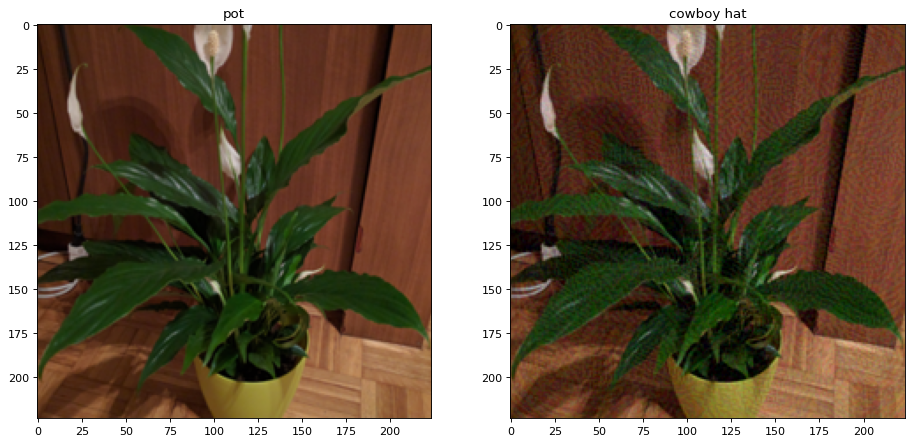

In [7]:
# Test the perturbation on the image
labels = open(os.path.join('python', 'data', 'labels.txt'), 'r').read().split('\n')

image_original = preprocess_image_batch([path_test_image], img_size=(256, 256), crop_size=(224, 224), color_mode="rgb")
label_original = np.argmax(f(image_original), axis=1).flatten()
str_label_original = labels[np.int(label_original)-1].split(',')[0]

# Clip the perturbation to make sure images fit in uint8
clipped_v = np.clip(undo_image_avg(image_original[0,:,:,:]+v[0,:,:,:]), 0, 255) - np.clip(undo_image_avg(image_original[0,:,:,:]), 0, 255)

image_perturbed = image_original + clipped_v[None, :, :, :]
label_perturbed = np.argmax(f(image_perturbed), axis=1).flatten()
str_label_perturbed = labels[np.int(label_perturbed)-1].split(',')[0]

# Show original and perturbed image
plt.figure(figsize=(14, 10), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(undo_image_avg(image_original[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_original)

plt.subplot(1, 2, 2)
plt.imshow(undo_image_avg(image_perturbed[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_perturbed)

plt.show()

In [8]:
tf_device.__exit__()